# Prédiction du churn client  
## Préparation des données


Dans ce notebook, nous préparons les données en vue de la modélisation.
Cette étape comprend le nettoyage des données, le traitement des valeurs
manquantes et la transformation des variables.


Objectifs :
- Nettoyer les incohérences du jeu de données
- Traiter les valeurs manquantes
- Transformer les variables catégorielles
- Préparer les jeux d’entraînement et de test


In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv("/Users/yassinedziba/churn-client/data/WA_Fn-UseC_-Telco-Customer-Churn.csv")


## Nettoyage de la variable `TotalCharges`

Lors de l’exploration des données, nous avons identifié une incohérence
dans la variable `TotalCharges`, qui est stockée sous forme de texte
alors qu’elle représente une variable numérique.
Certaines valeurs sont vides et correspondent principalement
à des clients très récents.


In [3]:
df["TotalCharges"].dtype

dtype('O')

In [4]:
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors = "coerce")

In [5]:
df["TotalCharges"].isnull().sum()

np.int64(11)

In [6]:
df[df["TotalCharges"].isnull()][["tenure", "TotalCharges"]].head()

,tenure,TotalCharges
488,0,NaN
753,0,NaN
936,0,NaN
1082,0,NaN
1340,0,NaN


Les valeurs manquantes de `TotalCharges` correspondent à des clients
ayant une ancienneté nulle.  
Dans ce cas, le montant total facturé peut raisonnablement être considéré
comme égal à 0.


In [7]:
df["TotalCharges"] = df["TotalCharges"].fillna(0)

In [8]:
df["TotalCharges"].isnull().sum()

np.int64(0)

## Séparation des variables explicatives et de la variable cible

Avant de procéder à la modélisation, nous séparons la variable cible
(`Churn`) des variables explicatives, puis nous divisons les données
en un jeu d’entraînement et un jeu de test.


In [9]:
y = df["Churn"]

In [11]:
X = df.drop(columns = ["Churn", "customerID"])

In [12]:
X.shape, y.shape

((7043, 19), (7043,))

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y,
    test_size = 0.2,
    random_state = 42,
    stratify = y)

La séparation est réalisée avec une proportion de 80 % pour
l’entraînement et 20 % pour le test.

L’option `stratify=y` permet de conserver la même proportion
de churn dans les deux jeux de données, ce qui est essentiel
dans un contexte de classes déséquilibrées.


In [14]:
y_train.value_counts(normalize = True), y_test.value_counts(normalize = True)

# les proportions doivent etre très proches


(Churn
 No     0.734647
 Yes    0.265353
 Name: proportion, dtype: float64,
 Churn
 No     0.734564
 Yes    0.265436
 Name: proportion, dtype: float64)

## Encodage des variables catégorielles

Les modèles de machine learning nécessitent des variables numériques.
Nous devons donc transformer les variables catégorielles tout en
préservant l’information qu’elles contiennent.


In [16]:
categorical_features = X.select_dtypes(include=["object"]).columns
numerical_features = X.select_dtypes(exclude=["object"]).columns

categorical_features, numerical_features

(Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
        'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
        'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
        'PaperlessBilling', 'PaymentMethod'],
       dtype='object'),
 Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object'))

Nous utilisons un encodage One-Hot pour les variables catégorielles,
qui est adapté aux modèles linéaires et aux modèles basés sur les arbres.
Les variables numériques sont laissées inchangées.


In [17]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [21]:
preprocessor = ColumnTransformer(
    transformers = [
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features), # handle_unknown="ignore", pour éviter les erreurs si une catégorie apparait dans le test
        ("num", "passthrough", numerical_features), # passthrough pour conserver les avriables numériques telles quelles
         ]
)



In [22]:
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test) # pas de fuite de données

In [25]:
X_train_processed.shape, X_test_processed.shape

((5634, 45), (1409, 45))

Les variables catégorielles ont été encodées à l’aide d’un
One-Hot Encoding, et les données sont désormais prêtes
pour l’entraînement des modèles de machine learning.


## Modèle de référence

Avant d’entraîner des modèles plus complexes, nous commençons
par un modèle de référence simple.
Ce modèle servira de point de comparaison pour évaluer
les gains apportés par des approches plus avancées.


Nous utilisons une régression logistique comme modèle de référence.
Ce modèle est simple, rapide à entraîner et facilement interprétable,
ce qui en fait un bon point de départ pour un problème de churn.


In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

In [29]:
log_reg = LogisticRegression(max_iter = 10000)
log_reg.fit(X_train_processed, y_train)

LogisticRegression(max_iter=10000)

In [30]:
y_pred = log_reg.predict(X_test_processed)

In [31]:
accuracy_score(y_test, y_pred)

0.8062455642299503

In [33]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          No       0.85      0.89      0.87      1035
         Yes       0.66      0.56      0.61       374

    accuracy                           0.81      1409
   macro avg       0.75      0.73      0.74      1409
weighted avg       0.80      0.81      0.80      1409



L’accuracy donne une première indication globale des performances,
mais elle est insuffisante dans un contexte de classes déséquilibrées.

Nous analysons donc également la précision, le rappel et le F1-score,
en particulier pour la classe `Yes` (clients ayant churné),
qui est la plus importante d’un point de vue métier.


La régression logistique fournit un modèle de référence interprétable, mais montre des limites sur la détection des clients churners, ce qui justifie l’utilisation de modèles plus flexibles

## Interprétation du modèle de régression logistique

La régression logistique estime la probabilité qu’un client churn
en fonction de ses caractéristiques.
Les coefficients du modèle indiquent l’effet de chaque variable
sur le log-odds de churn.


In [34]:
feature_names = preprocessor.get_feature_names_out()

In [35]:
coefficients = log_reg.coef_[0]

In [42]:
coef_df = pd.DataFrame({
    "variable" : feature_names, 
    "coefficient" : coefficients
}).sort_values(by="coefficient", ascending = False)

coef_df.head(10), coef_df.tail(10)

(                               variable  coefficient
 12     cat__InternetService_Fiber optic     0.922719
 32         cat__Contract_Month-to-month     0.715913
 28                 cat__StreamingTV_Yes     0.413365
 31             cat__StreamingMovies_Yes     0.413066
 39  cat__PaymentMethod_Electronic check     0.299583
 14               cat__OnlineSecurity_No     0.295331
 10               cat__MultipleLines_Yes     0.276732
 23                  cat__TechSupport_No     0.269631
 36            cat__PaperlessBilling_Yes     0.234302
 22            cat__DeviceProtection_Yes     0.207654,
                                      variable  coefficient
 8                       cat__MultipleLines_No    -0.155274
 27       cat__StreamingTV_No internet service    -0.218738
 15    cat__OnlineSecurity_No internet service    -0.218738
 24       cat__TechSupport_No internet service    -0.218738
 21  cat__DeviceProtection_No internet service    -0.218738
 18      cat__OnlineBackup_No internet servic

Un coefficient positif indique que la variable augmente
la probabilité de churn.
Un coefficient négatif indique que la variable réduit
la probabilité de churn.

Plus la valeur absolue du coefficient est élevée,
plus l’impact de la variable est important.


Les variables associées à une augmentation du churn
incluent notamment certains types de contrats courts
et des charges mensuelles élevées.

À l’inverse, une ancienneté élevée et des contrats
de longue durée sont associés à une diminution
du risque de churn.


<Axes: ylabel='variable'>

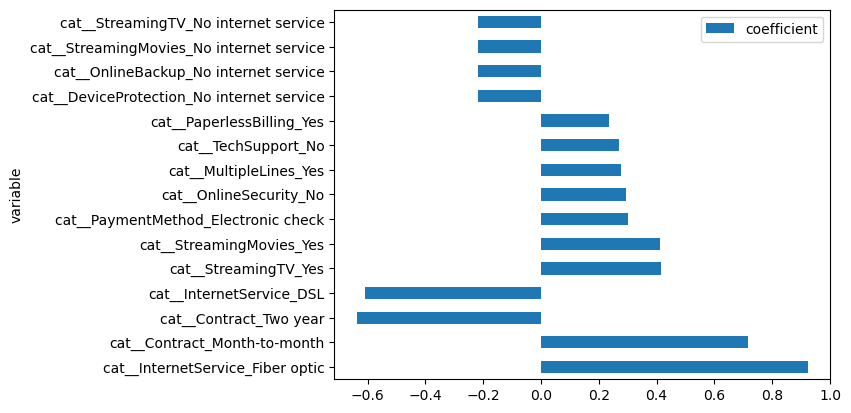

In [48]:
coef_df_top = coef_df.sort_values(
    by = "coefficient", 
    key = abs, # on trie en valeur absolue
    ascending = False).head(15)

coef_df_top.set_index("variable").plot(kind = "barh")

L’interprétation des coefficients de la régression logistique
doit être faite avec prudence, notamment en présence de
variables corrélées.

Cependant, ce modèle offre une bonne première compréhension
des facteurs associés au churn.


La régression logistique permet d’identifier les facteurs associés au churn, notamment l’ancienneté et le type de contrat, tout en offrant une interprétation directe des effets des variables.